In [1]:
from diffusers import AutoPipelineForText2Image, DEISMultistepScheduler
import torch,os,sys,random
model_name="Inkpunk-Diffusion"
pipe = AutoPipelineForText2Image.from_pretrained(model_name, torch_dtype=torch.float16, variant="fp16")
pipe.scheduler = DEISMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")



Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/25 [00:00<?, ?it/s]

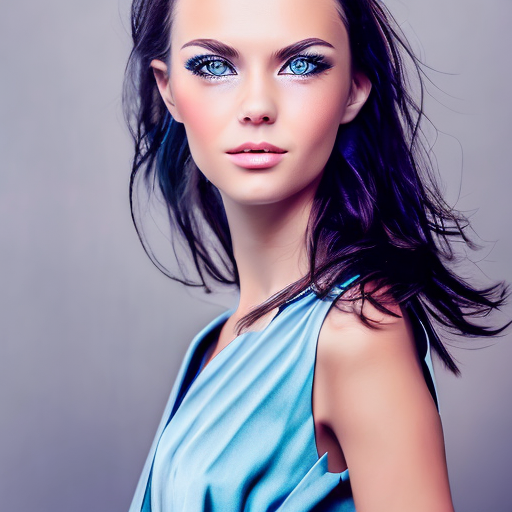

In [2]:
prompt = "photo of pretty girl with short dark hair, beautiful face and blue eyes,wearing elegant dress, steel metal, elegant, sharp focus, soft lighting, vibrant colors"
seed=random.randint(1,100000000)
generator = torch.manual_seed(seed)
image = pipe(prompt, generator=generator, num_inference_steps=25).images[0] 
img_filename= os.path.join("./img/", prompt.replace(" ", "_") +str(seed)+".png")
image.save(img_filename)
image

In [ ]:
# safertensors
from diffusers import StableDiffusionPipeline
import torch,os,sys
pipeline = StableDiffusionPipeline.from_single_file("./models/deliberate_v3.safetensors")
pipeline.to("cuda")


## generate images

In [ ]:
import random
seed=random.randint(1,100000000)
seed

In [ ]:
prompt = "photo of pretty lady with short pink hair, beautiful face and blue eyes,wearing elegant dress, steel metal, elegant, sharp focus, soft lighting, vibrant colors"
seed=random.randint(1,100000000)
generator = torch.manual_seed(seed)
image = pipeline(prompt, generator=generator, num_inference_steps=25).images[0] 
img_filename= os.path.join("./img/", prompt.replace(" ", "_") +str(seed)+".png")
image.save(img_filename)
image

In [ ]:
# StableDiffusionXL
from diffusers import StableDiffusionXLPipeline
import torch

pipe = StableDiffusionXLPipeline.from_single_file("./models/zavychromaxl_v12.safetensors")
pipe.to("cuda")

prompt = "Astronaut in a jungle, cold color palette, muted colors, detailed, 8k"
image = pipe(prompt=prompt,generator=generator, num_inference_steps=25).images[0]
img_filename= os.path.join("./img/", prompt.replace(" ", "_") +str(seed)+".png")
image.save(img_filename)
image


In [41]:
from ctypes import *
from struct import pack, unpack
all_pixels = 2048*2052
import numpy as np
IMGdata=(c_byte*all_pixels*3)()
barray = np.frombuffer(IMGdata, dtype=np.byte)
#print(IMGdata,barray.shape)
array_data=[]
for i in range(0,len(barray),3):
    array_data.append(int.from_bytes(barray[i:i+3], byteorder = 'little', signed = False))
img_data=np.array(array_data).reshape(2048,2052)

print(img_data.shape)

(2048, 2052)


In [39]:
all_pixels = 2048*2052
import numpy as np
IMGdata=(c_byte*all_pixels*3)()
# First convert the buffer to an array of 3-vectors of uint8s
a3 = np.frombuffer(IMGdata, dtype=np.uint8).reshape(-1, 3)
print(a3.shape)
# Now sign-extend it to an array of 4-vectors of uint8s
signs = (a3[..., 0] > 0x80) * 0xFF
a4 = np.concatenate((signs.reshape(-1, 1), a3), axis=1)

# Now convert that to an array of int32s
i = a4.view(np.int32)
f=i.astype(np.int32)
# img_data=np.array(i).reshape(2048,2052)
# print(img_data.shape)

def byte3toint32(byte3,width:int=2048,height:int=2052):
    # First convert the buffer to an array of 3-vectors of uint8s
    b3 = np.frombuffer(byte3, dtype=np.uint8).reshape(-1, 3)
    # Now sign-extend it to an array of 4-vectors of uint8s
    signs = (b3[..., 0] > 0x80) * 0xFF
    b4 = np.concatenate((signs.reshape(-1, 1), b3), axis=1)

    # Now convert that to an array of int32s
    i = b4.view(np.int32)
    return np.array(i).reshape(width,height)
#print(byte3toint32(IMGdata))
    

(4202496, 3)


ValueError: cannot reshape array of size 16809984 into shape (2048,2052)

In [51]:
def fromJPG2_2int32_stbyst(byte3,width:int=2048,height:int=2052): # step by step
    #img = imread(fnme)
    img=np.frombuffer(byte3, dtype=np.uint8).reshape(width,height, 3)
    # create a (w,h,4) array and copy original
    re = np.zeros((width, height, 4), dtype=np.uint8) 
    re[:, :, :-1] = img
    # lineup to a byte structure ready for ' frombuffer'
    re1 = re.reshape(width*height * 4)
    by = re1.tobytes()
    # got it just convert to int
    cols = np.frombuffer(by, 'I')
    return cols
print(fromJPG2_2int32_stbyst(IMGdata).reshape(2048,2052))
def fromJPG2_2int32_v0(byte3,width:int=2048,height:int=2052): # more compact & efficient
    img = np.frombuffer(byte3, dtype=np.uint8).reshape(width,height, 3)
    re = np.zeros((img.shape[0], img.shape[1], 4), dtype=np.uint8)
    re[:, :, :-1] = img
    return np.frombuffer(re.reshape(img.shape[0] * img.shape[1] * 4).tobytes(), 'I')

def fromJPG2_2int32(byte3,width:int=2048,height:int=2052): # even better using numpy.c_[]
    img = np.frombuffer(byte3, dtype=np.uint8).reshape(width,height, 3)
    #img = np.c_[img, np.zeros((img.shape[0], img.shape[1], 1), dtype=np.uint8)]
    img = np.c_[np.zeros((img.shape[0], img.shape[1], 1), dtype=np.uint8),img]
    return np.frombuffer(img.reshape(img.shape[0] * img.shape[1] * 4).tobytes(), 'I')

print(fromJPG2_2int32(IMGdata).reshape(2048,2052))

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
